<a href="https://colab.research.google.com/github/matteo9924/youtube/blob/main/Challenge_2_ABOUDARAM_CHEVALLIER_FREMAUX_LR_merged_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Challenge 2 : Toxicité
======


## Préliminaires

### Import des librairies et de la base de données

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
df = pd.read_csv('challenge_youtube_toxic.csv', sep=';',decimal=',', encoding='iso-8859-1' )

### Type des objets 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46102 entries, 0 to 46101
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id_court           46102 non-null  object 
 1   video_id                 46102 non-null  object 
 2   channel_id               46102 non-null  object 
 3   nbrMot                   46102 non-null  int64  
 4   nbrMotInsulte            46102 non-null  int64  
 5   nbrMotAllong             46102 non-null  int64  
 6   nbrMotMAJ                46102 non-null  int64  
 7   nbrExclMark              46102 non-null  int64  
 8   nbrQuestMark             46102 non-null  int64  
 9   nbrMotMoyenne            46102 non-null  float64
 10  nbrMotInsulteMoyenne     46102 non-null  float64
 11  nbrMotAllongMoyenne      46102 non-null  float64
 12  nbrMotMAJMoyenne         46102 non-null  float64
 13  nbrExclMarkMoyenne       46102 non-null  float64
 14  nbrQuestMarkMoyenne   

Les objets paraissent être bien typés (peut-être remplacés les object par des strings ?)

### Fonction qui permet de lire les videos 

In [ ]:
def link(df):
  id=df['video_id_court']
  print("https://www.youtube.com/watch?v="+id)


#I. Statistiques	descriptives et	feature	engineering 


## 1 Statistiques	uni- et	multi-dimensionnelles 
Evaluation	de	la	qualité	des	données,	compréhension	de	la	structure,	des	liens	entre	variables

### 1.1Nettoyage des données 



*   On commmence par supprimer la dernière ligne qui est inutile 



In [ ]:
df=df.drop(columns='Unnamed: 27')



*   Regardons si il ne manque aucune valeur dans le tableau 



In [ ]:
df.isnull().sum()

video_id_court             0
video_id                   0
channel_id                 0
nbrMot                     0
nbrMotInsulte              0
nbrMotAllong               0
nbrMotMAJ                  0
nbrExclMark                0
nbrQuestMark               0
nbrMotMoyenne              0
nbrMotInsulteMoyenne       0
nbrMotAllongMoyenne        0
nbrMotMAJMoyenne           0
nbrExclMarkMoyenne         0
nbrQuestMarkMoyenne        0
thread_count               0
comment_count              0
message_count              0
discussion_count           0
distinct_authors_count     0
authors_3channels_count    0
liked_authors_count        0
channel_name               0
subscriberCount            0
viewCount                  0
categorie_new              0
categ_inst                 0
dtype: int64

Il n'y a donc aucune cellule manquante dans le tableau 





* Regardons desormais  la description du dataset

In [ ]:
df.describe()

nbrMot  nbrMotInsulte  ...  subscriberCount     viewCount
count   46102.000000   46102.000000  ...     46102.000000  4.610200e+04
mean     1435.853564       9.418225  ...    172108.752744  9.255061e+07
std      7670.789422      61.616732  ...    119508.318824  6.778302e+07
min         0.000000       0.000000  ...         0.000000  3.109100e+04
25%        18.000000       0.000000  ...     87793.000000  4.635634e+07
50%        72.000000       0.000000  ...    180173.000000  6.388093e+07
75%       398.000000       3.000000  ...    217835.000000  1.321257e+08
max    662808.000000    7227.000000  ...    568615.000000  2.414350e+08

[8 rows x 21 columns]

On remarque des valeurs de nombres d'abonnés potentiellement incohérente, quel média n'a aucun abonné ? 

In [ ]:
df[df['subscriberCount']==0]['channel_name'].unique()

array(['Slate.fr', 'arret_sur_image'], dtype=object)

Apparemment les valeurs du nombre d'abonnés de Slate.fr et Arrêt sur Images sont inconnus, après vérification, ces chaînes ont en effet masqué leur nombres d'abonnés sur youtube.

On remarque aussi que certaines vidéos n'ont aucun commentaire, on peut donc envisager leur suppression, elle n'apporte que très peu d'information...

In [ ]:
#suppression des videos sans commentaires (ie nbrMot = 0)
No_comment= df[ df['nbrMot'] == 0 ].index
df.drop(No_comment , inplace=True)

* Verifions qu'une video ne sorte pas trop du lot 

In [ ]:
link(df[df['nbrMotInsulte']==max(df['nbrMotInsulte'])])

14922    https://www.youtube.com/watch?v=FFJBEPLe5Sg
Name: video_id_court, dtype: object


C'est la vidéo la plus toxique du dataset, celle qui rassemble le plus d'insultes. On va la retirer car elle semble sortir du lot.

In [ ]:
df=df.drop(df[df['nbrMotInsulte']==max(df['nbrMotInsulte'])].index)

### 1.2 Scale et correlation

* On crée maintenat une variable dfScale qui correspond au Dataframe mais sans les colonnes de textes et avec toutes les valeurs scaled 

In [ ]:
from sklearn.preprocessing import StandardScaler
df2= df.copy()

#delete the string columns
df2.drop(df2.columns[[0,1,2,22,25,26]],axis='columns',inplace=True)
X = df2.to_numpy() 
std_scale = StandardScaler().fit(X) #scale the data
X_scaled = std_scale.transform(X)

dfScale=pd.DataFrame(X_scaled,columns=df2.columns,index=df2.index)
dfScale.head()

nbrMot  nbrMotInsulte  ...  subscriberCount  viewCount
0  0.340276       0.169117  ...         1.404485   1.959659
1 -0.198402      -0.140666  ...         0.149500   0.583694
2  0.338995       1.137190  ...         1.404485   1.959659
3 -0.201818      -0.179389  ...        -1.416472  -1.328936
4 -0.097498      -0.121305  ...        -1.189262  -1.266537

[5 rows x 21 columns]

In [ ]:
df.head()

video_id_court  ...        categ_inst
0    Uvvsvw_wxOs  ...      Pure Players
1    mCy1ZBdttwA  ...                TV
2    iU3MyHMK5nU  ...      Pure Players
3    ZUim3AeURtk  ...  Presse_regionale
4    n5Tg2vhLCAM  ...  Presse nationale

[5 rows x 27 columns]

* grace a cela on effectue la matrice de correlation

In [ ]:
import plotly.graph_objects as go
corr = dfScale.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
c=corr.copy()
c[mask.transpose()]=None
fig = go.Figure(data=go.Heatmap(
        z=c,
        x=corr.index,
        y=corr.index,
        colorscale='amp',
        hoverongaps = False))
fig.layout.height = 800
fig.layout.width = 800
fig.layout.plot_bgcolor = 'white'
fig

Ce graphe nous permet de trouver différentes corrélations entre les variables. Outre celles évidentes, on remarque que le nombre de point d'interrogation semble correlé avec le nombre d'insulte (0.85). C'est d'ailleurs l'indice de corrélation le plus élevé avec le champ nombre d'insulte dans ce graphe.

Ce qui nous interesse le plus c'est la correlation entre le nombre d'insultes et les autres vorables, regardons ceci plus en detail:

In [ ]:
df.corr()['nbrMotInsulte'].sort_values(ascending = True)

nbrExclMarkMoyenne        -0.011708
nbrMotMAJMoyenne          -0.000782
nbrMotAllongMoyenne        0.004870
nbrQuestMarkMoyenne        0.008376
nbrMotMoyenne              0.049053
nbrMotInsulteMoyenne       0.056559
viewCount                  0.069136
subscriberCount            0.099890
thread_count               0.684022
nbrExclMark                0.699465
distinct_authors_count     0.722562
discussion_count           0.740572
nbrMotAllong               0.750195
nbrMotMAJ                  0.750690
liked_authors_count        0.751664
authors_3channels_count    0.777496
message_count              0.808020
comment_count              0.827242
nbrQuestMark               0.836972
nbrMot                     0.850012
nbrMotInsulte              1.000000
Name: nbrMotInsulte, dtype: float64

Les correlations les plus fortes avec le nombre d'insultes sont avec: 

*   Le nombre de mots 
*   Le nombre de point d'interrogation
*   Le nombre	de	commentaires qui	sont	des	réponses	à	un	top	level
*   Le nombre total de commentaires 
*   Le nombre de mots en majuscule
...

Globalement certaines correlations sont logiques, que le nombre d'insulte soit corrélé avec le nombre de mots n'est pas une surprise.

Les majuscules sont liés a aux insultes car peuvent etre un signe d'énérvement. 

Il est interessant de remarquer que le nombre de commentaire en réponse a un top level est lié aux nombre d'insulte. On pourrait pensser qu'une réponse a un commentaire top level est postée lorsqe l'urilisateur n'est pas d'accord avec le commentaire top level. pourrait alors s'en suivre un debat. Or, lorque la discution s'intenssifie et s'allonge on a plus de chance de voir apparaitre des insultes et injures.

Extrangement le nombre de point d'exclamation est moins lié aux nombre d'insultes que les points d'interrogations. En effet les points d'exclamations sont liés a l'énervement et l'on pourrait penser que leur présence indiquerait des insultes. Lorsque l'on y reflechit, le nombre de point d'interrogation est lié aux nombre de questions et plus il y a de questions plus il y a de debats en commentaires. Le nombre de débats amène donc visiblement a des insultes.





### 1.3 Influence du type de presse


In [ ]:
fig = px.scatter_matrix(df, dimensions=["nbrMot", "nbrMotInsulte", 'nbrMotAllong', "nbrMotMAJ","nbrExclMark","nbrQuestMark"],color='categ_inst', height = 760)
fig

On observe dans la plupart de ces graphes des tas, y compris pour des corrélations évidentes ( par exemple le nombre de mot par rapport au nombre de majuscule), ce qui signifie que cette approche est surement incompléte et qu'il faut prendre en compte la réputation du média pour obtenir des résultats interprétables.

*On remarque un point vert systématique en haut a droite la fameuse video que nous avons retiré.*


* On va maintenant établir un classement des différents médias en fonction de leur taux d'insultes moyen.

In [ ]:
df.groupby(['channel_name'])['nbrMotInsulteMoyenne','nbrMotMAJMoyenne','nbrQuestMark','nbrMotMoyenne'].mean().sort_values('nbrMotInsulteMoyenne')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



nbrMotInsulteMoyenne  ...  nbrMotMoyenne
channel_name                                                 ...               
ZDNet.fr                                           0.000000  ...      11.500000
France Net Infos journal                           0.010417  ...      11.151235
DNA - DerniÌå_res Nouvelles d'Alsace              0.040000  ...       8.532500
Le Monde diplomatique                              0.044444  ...      43.770233
La Croix                                           0.045200  ...      27.538063
Alternatives Economiques Officiel                  0.052970  ...      33.522601
Gala                                               0.072390  ...      15.630420
Courrier international                             0.075642  ...      29.165328
Lundi Matin                                        0.079994  ...      23.858987
AgoraVoxFrance                                     0.091186  ...      18.133663
Slate.fr                                           0.094656  ...      24.664529
Le Monde                                           0.096943  ...      28.310787
Famille_chretienne                                 0.100019  ...      35.455191
Reporterre. Net                                    0.113890  ...      33.331048
TVLaTribune                                        0.114331  ...      32.915447
Corse-Matin Presse                                 0.114703  ...      15.814572
Redaction JOL Press                                0.116667  ...      22.195833
Obs                                                0.120266  ...      25.507804
Paris Match                                        0.126453  ...      24.082297
Acrimed                                            0.129163  ...      24.060274
LCI                                                0.135470  ...      20.424513
La Voix du Nord                                    0.137408  ...      15.345053
L'Express                                          0.138183  ...      23.829847
Fakirpresse                                        0.141989  ...      31.724390
Orient XXI                                         0.143491  ...      30.829934
Ouest-France                                       0.146298  ...      16.286409
Le Parisien                                        0.151796  ...      20.887611
Mediapart                                          0.152812  ...      41.977339
Le Figaro                                          0.155034  ...      25.757470
la_bas_si_jy_suis                                  0.155222  ...      32.401343
20MinutesFR                                        0.155548  ...      20.373181
Dauphine_libere                                    0.155783  ...      16.548298
Lequipe                                            0.158989  ...      15.592392
La Manche Libre                                    0.160223  ...      16.237182
Causeur                                            0.160446  ...      44.599867
LeHuffPost                                         0.161999  ...      22.303431
Les Echos                                          0.168092  ...      30.394675
LibÌå©ration                                      0.169540  ...      29.445402
Telegramme                                         0.171680  ...      20.453284
La Provence                                        0.179831  ...      18.302494
Humanite                                           0.180180  ...      39.639737
Le Point                                           0.186005  ...      23.143737
Sud Ouest                                          0.186031  ...      23.414440
Nice_Matin                                         0.190370  ...      19.013749
StreetPress                                        0.198350  ...      19.782858
France-Soir                                        0.203939  ...      21.996945
hors_serie                                         0.205949  ...      36.912810
metronews                                          0.214455  ...      25.658125
Corse Net Infos                        

On remarque que le nombre d'insulte moyen est très différent en fonction des médias. La majorité des médias ont des taux comparables à peu près comparable (entre 0.1 et 0.25) mais certain média ont des taux beaucoup plus important allant jusqu'à 0.60.  

* Nous allons maintenant essayer de regarder quels sont les types médias qui regrouppent le plus de commentaires insutants dans leurs vidéos:

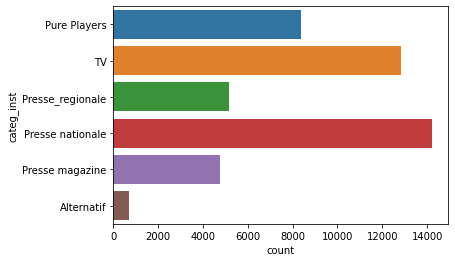

In [ ]:
sns.countplot(y="categ_inst", data=df)

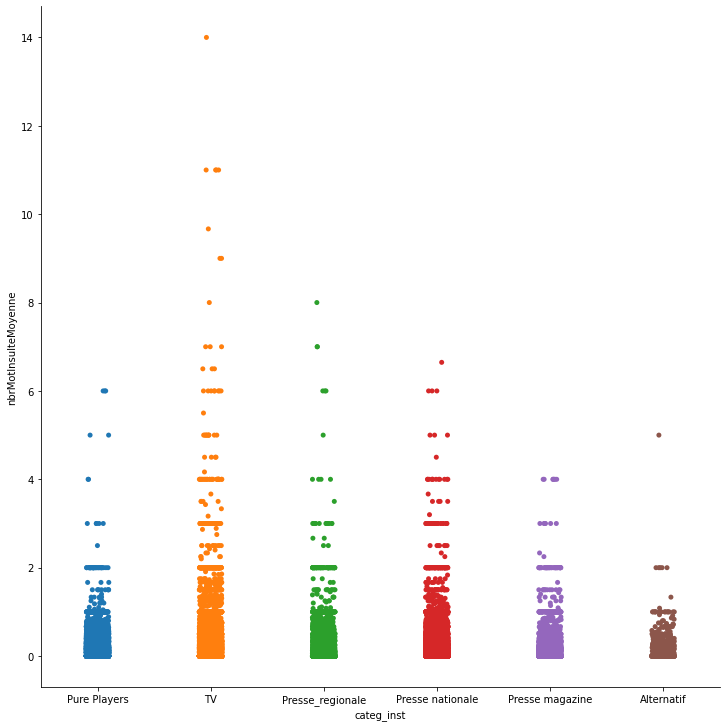

In [ ]:
sns.catplot(x="categ_inst", y="nbrMotInsulteMoyenne", data=df,height=10)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



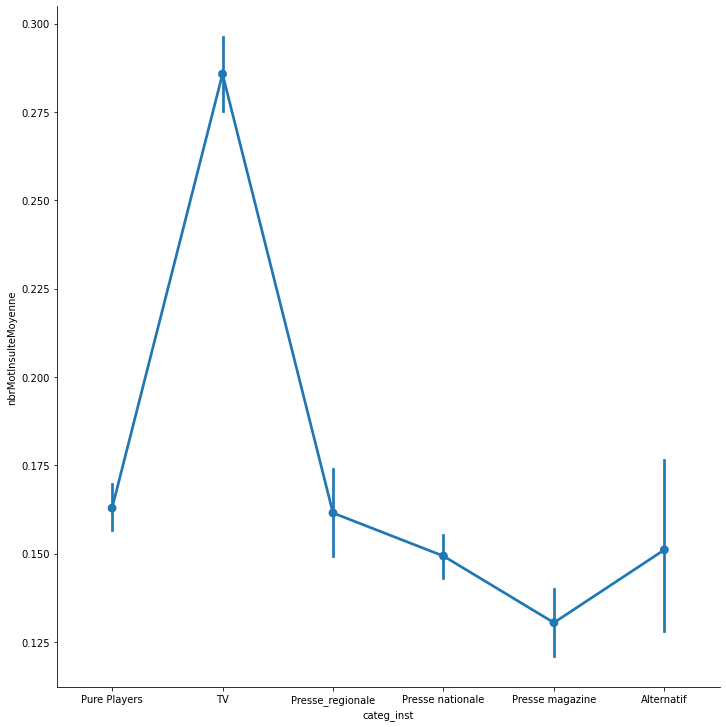

In [ ]:
sns.factorplot(x="categ_inst", y="nbrMotInsulteMoyenne", data=df,height=10)

Sur le premier diagramme on voit bien que les videos de Télévisions possèdent les plus gros outliers en terme d'insultes moyennes par commentaires. Et cela malgré le fait que la presse nationale represente la mejeure partie des vidéos. Néanmoins les données sont tassés d'ou l'utilité du deuxieme diagramme. Il Montre que c'est bien les vidéos de  Télévision qui regroupent le plus d'insultes en moyennes. Les magazines alternatifs ont peu d'insultes en moyenne mais possède toutefois le plus grand écart type, il est difficile donc de faire une conclusuon sur les vidéos des médias alternatifs.

* maintenant les medias en les classant par public visé 

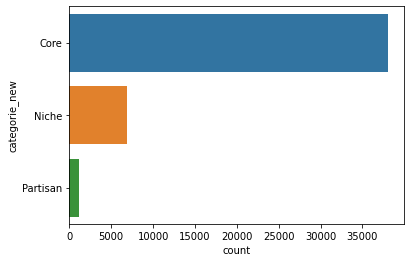

In [ ]:
sns.countplot(y="categorie_new", data=df)

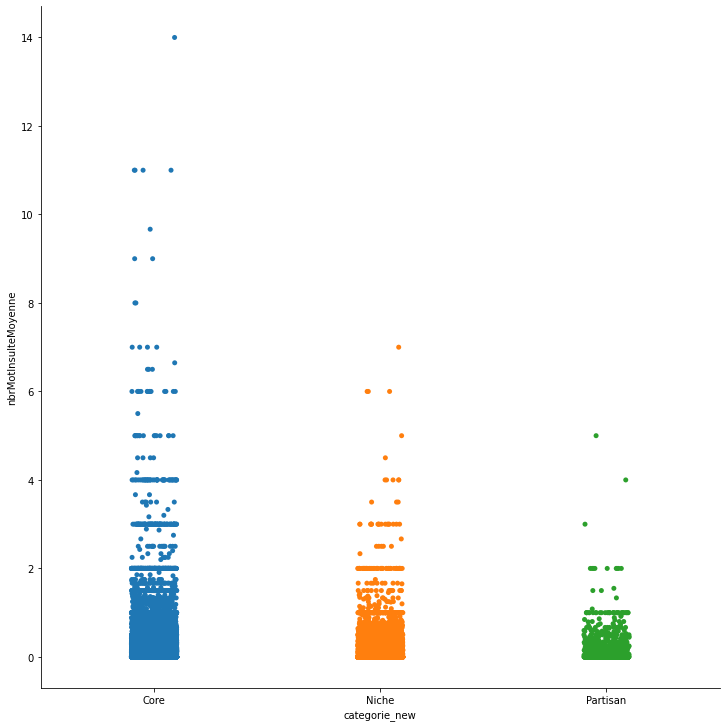

In [ ]:
sns.catplot(x="categorie_new", y="nbrMotInsulteMoyenne", data=df,height=10)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



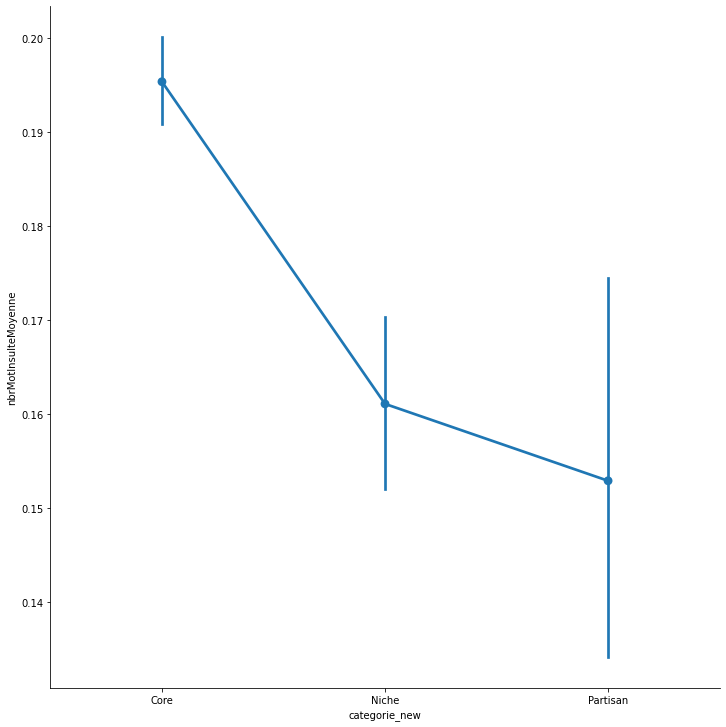

In [ ]:
sns.factorplot(x="categorie_new", y="nbrMotInsulteMoyenne", data=df,height=10)

Contrairement à ce que l'on pourrait croire, ce ne sont pas les vidéos des médias partisans qui regroupent le plus d'insultes moyennes par commentaire. Encore une fois l'écartée est grand, c'est donc qu'il existe certainement des sous catégories dans les médias partisans, certains médias étant très corrects et d'autres plus véhéments.

### 1.4 verification préalables



Regardons désormais si le nombre d'insulte moyenne nous permet bien de retrouver le nombre d'insultes total:

In [ ]:
((df['nbrMotInsulteMoyenne']/df['nbrMotMoyenne']*df['nbrMot'])-df['nbrMotInsulte']).mean()

3.032482673357079e-08

On remarque que l'on peut prédire parfaitement le nombre d'insulte à partir de la moyenne des insultes, il faudra donc veiller à ne pas inclure la moyenne dans nos modèles qui ne serait pas obtensible sans avoir le nombre d'insultes dans la pratique.

### 1.5 Comparaison entre un commentaire injurieux moyen et un commentaire normal

On va selectionner les videos qui ont seulement 1 commentaire et dont ce commentaire est injurieux afin de pouvoir obtenir un dataset composé de commentaires injurieux et de pouvoir les classifiés. ce qui nous sera utile par la suite .


In [ ]:
 df_1insult=df.copy()
No_insults= df_1insult[ df_1insult['nbrMotInsulte'] == 0 ].index
df_1insult.drop(No_insults , inplace=True)
too_much_mess= df_1insult[ df_1insult['message_count'] > 1 ].index
df_1insult.drop(too_much_mess, inplace=True)

df_1insult.describe()

nbrMot  nbrMotInsulte  ...  subscriberCount     viewCount
count  1340.000000    1340.000000  ...      1340.000000  1.340000e+03
mean     49.889552       1.667164  ...    141137.938806  8.234924e+07
std      88.588254       1.218342  ...     91441.532245  6.001357e+07
min       1.000000       1.000000  ...         0.000000  3.109100e+04
25%       9.750000       1.000000  ...     49670.000000  2.968923e+07
50%      22.000000       1.000000  ...    180173.000000  6.388093e+07
75%      53.250000       2.000000  ...    189971.000000  1.321257e+08
max    1304.000000      14.000000  ...    568615.000000  2.414350e+08

[8 rows x 21 columns]

### 1.6 PCA

In [ ]:
def PCA_VarSwap(dfScale):
  var=[]
  x=[]
  for i in range(1,19):
    pca = PCA(n_components=i)
    components = pca.fit_transform(dfScale)
    var.append(pca.explained_variance_ratio_.sum()*100)
    x.append(i)
    #print('For',i,' components, total retained variance =',var[-1])
  return px.line(x=x,y=var, title='Retained variance in function of the number of components')
PCA_VarSwap(dfScale.drop(['nbrMotInsulte','nbrMotInsulteMoyenne'],axis=1))

La courbe ci dessus nous montre qu'en faisant une PCA avec 9 variables, on ne pert que 5% de l'information contenue dans le dataset avec moitié moins de features.

##2. Features enginnering

Création d'un dataset contenant les 9 neufs composantes calculées par la PCA


In [ ]:
pca = PCA(n_components=9)
components = pca.fit_transform(dfScale.drop(['nbrMotInsulte','nbrMotInsulteMoyenne'],axis=1))

In [ ]:
X=pd.DataFrame(components)
X['Y']=dfScale['nbrMotInsulte'].to_numpy()

###Création de datasets d'entrainement et de tests.

In [ ]:
train=X.sample(frac=0.6)
test_validation=X.drop(train.index)
test = test_validation.sample(frac=0.5)
validation = test_validation.drop(test.index)

In [ ]:
#variable d'entrainement
X_train=train.drop('Y',axis=1)
Y_train=train['Y']

In [ ]:
#variable
X_test=test.drop('Y',axis=1)
Y_test=test['Y']

In [ ]:
X_validation=validation.drop('Y',axis=1)
Y_validation = validation['Y']

In [ ]:
Y_train.head()

7603     -0.179389
10882    -0.179389
5012     16.723164
26725    -0.160028
33302     3.092697
Name: Y, dtype: float64

In [ ]:
X_train.head()

0         1         2  ...         6         7         8
7603   -0.860624  1.130959 -1.272206  ... -0.084185 -0.026936 -0.040592
10882  -0.572288 -0.601911  0.083577  ...  0.182706  0.133430  0.104371
5012   44.054781  0.077749 -1.691045  ...  1.583336  5.099556 -8.878950
26725  -0.554493  1.817373 -0.542486  ...  0.510625 -0.044026  0.046486
33302   9.770347  0.824738 -0.230470  ... -0.442691 -2.283125  1.021196

[5 rows x 9 columns]

#II. Benchmark	des	méthodes	de	régression	pour	prédire	le	nombre	d’insultes	liées	à	une	vidéo

##1. Regression linéaire

In [ ]:
lreg = LinearRegression().fit(X_train, Y_train)
print("Le coefficient de détermination est de",lreg.score(X_train, Y_train),"pour les variables d'entraînement \nOn obtient un score de", lreg.score(X_test, Y_test),"pour le set de test")

Le coefficient de détermination est de 0.7714606904233949 pour les variables d'entraînement 
On obtient un score de 0.6917572361250812 pour le set de test


Les scores de test et de validation sont proches, il n'y a pas d'overfitting. Le score obtenu aux alentours de 0.75 est bon pour une première approche trés simple par regression linéaire.

##2. SVM 


Avec les paramètres par défault

In [ ]:
scoresV,scoresT=[],[]
for C in np.linspace(0.01,20,10):
  SVMreg = svm.SVR(C=C,gamma=0.0001)
  SVMreg.fit(X_train, Y_train)
  scoresV.append(SVMreg.score(X_validation, Y_validation))
  scoresT.append(SVMreg.score(X_train, Y_train))
#print("Le coefficient de détermination est de",SVMreg.score(X_train, Y_train),"pour les variables d'entraînement \nOn obtient un score de", SVMreg.score(X_test, Y_test),"pour le set de test")

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.linspace(0.01,20,10), y=scoresV, name="Validation Set",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=np.linspace(0.01,20,10), y=scoresT, name="Training Set",
                    line_shape='linear'))
fig.update_xaxes(type="log",title_text='C')
fig.update_yaxes(title_text='Score')
fig.update_layout(dict(title='Score by C'))

On peut prendre C=5 pour maximiser le score en évitant l'overfitting. Les résultats restent mauvais sur le validation set et le score ne dépasse pas les 0.17.
Essayons de faire varier le gamma.

In [ ]:
scoresV,scoresT=[],[]
for gamma in np.logspace(-8,0,20):
  SVMreg = svm.SVR(gamma=gamma, C=2)
  SVMreg.fit(X_train, Y_train)
  scoresV.append(SVMreg.score(X_validation, Y_validation))
  scoresT.append(SVMreg.score(X_train, Y_train))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.logspace(-8,0,20), y=scoresV, name="Validation Set",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=np.logspace(-8,0,20), y=scoresT, name="Training Set",
                    line_shape='linear'))
fig.update_xaxes(type="log",title_text='Gamma')
fig.update_yaxes(title_text='Score')
fig.update_layout(dict(title='Score by gamma'))

In [ ]:
scoresV,scoresT=[],[]
gammas=np.logspace(-8,0,5)
Cs=np.linspace(0.01,20,5)
for gamma in gammas:
  for C in Cs:
    print(gamma,C)
    SVMreg = svm.SVR(gamma=gamma, C=C)
    SVMreg.fit(X_train, Y_train)
    print(SVMreg.score(X_validation, Y_validation),SVMreg.score(X_train, Y_train))
    scoresV.append(SVMreg.score(X_validation, Y_validation))
    scoresT.append(SVMreg.score(X_train, Y_train))

In [ ]:
fig = go.Figure(data=[go.Surface(z=np.array(scoresV).reshape(5,5), x=Cs, y=gammas)])
fig.add_trace(go.Surface(z=np.array(scoresT).reshape(5,5), x=Cs, y=gammas,colorscale='blues'))
fig.update_layout(scene = dict(yaxis =dict(type="log",title_text="Gamma"),
                               xaxis =dict(title_text="C"),
                               zaxis =dict(title_text="Score")
                              ))

In [ ]:
SVMreg = svm.SVR(gamma=0.0001, C=5)
SVMreg.fit(X_train, Y_train)
print(SVMreg.score(X_test,Y_test))

0.5558261674578873


Pour les valeurs qui maximisent le score de validation on obtient un score de test de 0.75 !

##3. kNN regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
train=X.sample(frac=0.6)
test_validation=X.drop(train.index)
test = test_validation.sample(frac=0.5)
validation = test_validation.drop(test.index)

#variable d'entrainement
X_train=train.drop('Y',axis=1)
Y_train=train['Y']

#variable de test
X_test=test.drop('Y',axis=1)
Y_test=test['Y']

#variable de validation
X_validation=validation.drop('Y',axis=1)
Y_validation = validation['Y']

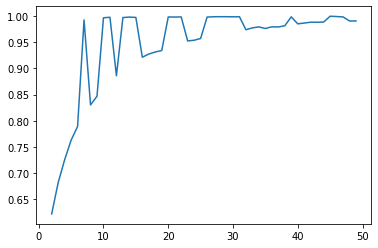

In [ ]:
#testons la méthode Knn pour un nombre différents de voisins
error_rate = []
for k in range(2,50):
  clf=KNeighborsRegressor(k)
  clf.fit(X_train,Y_train)
  Y_pred=clf.predict(X_validation)
  error_rate.append(np.mean(Y_pred != Y_validation))

plt.figure()
plt.plot([i for i in range(2,50)], error_rate)
plt.show()

L'erreur quadratique est plus faible pour un nombre de voisin petit. On va donc prendre k=2.

In [ ]:
clf=KNeighborsRegressor(2)
clf.fit(X_train,Y_train)
print(clf.score(X_train,Y_train), clf.score(X_test,Y_test))

0.8731404361497858 0.7466994087910339


On constate un certain décalage (0.2) entre les valeurs de score du set d'entraînement et le score du set de test. On en conclut que cette méthode avec ces données engendre un peu d'overfitting.

##4. Tree decision


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [ ]:
train=X.sample(frac=0.6)
test_validation=X.drop(train.index)
test = test_validation.sample(frac=0.5)
validation = test_validation.drop(test.index)

#variable d'entrainement
X_train=train.drop('Y',axis=1)
Y_train=train['Y']

#variable de test
X_test=test.drop('Y',axis=1)
Y_test=test['Y']

#variable de validation
X_validation=validation.drop('Y',axis=1)
Y_validation = validation['Y']

In [ ]:
clf = tree.DecisionTreeRegressor(criterion = "mse", max_depth = 6, min_samples_split=3, min_samples_leaf=1)
clf.fit(X_train, Y_train)
print(clf.score(X_train,Y_train),clf.score(X_test,Y_test))


0.9076305889157138 0.7134253261189464


On constate un  décallage entre le score du dataset d'entraînement et le dataset de test up peu plus important que pour la méthode précédente.
Cependant les scores restent meilleurs
On en conclut qu'il y a un  plus d'overfitting mais qu'elle est plus efficace.

##5. Random forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [ ]:
train=X.sample(frac=0.6)
test_validation=X.drop(train.index)
test = test_validation.sample(frac=0.5)
validation = test_validation.drop(test.index)

#variable d'entrainement
X_train=train.drop('Y',axis=1)
Y_train=train['Y']

#variable de test
X_test=test.drop('Y',axis=1)
Y_test=test['Y']

#variable de validation
X_validation=validation.drop('Y',axis=1)
Y_validation = validation['Y']

In [ ]:
#We look for the number of estimator the most appropriate to decrease the error and increase the score
#do not revive 

score=[]
meanSquaredError=[]
for i in range(1,50):  
  rg= RandomForestRegressor(n_estimators=i, random_state=0)
  rg.fit(X_train, Y_train)
  Y_pred = rg.predict(X_validation)
  score.append(rg.score(X_validation,Y_validation))
  meanSquaredError.append(metrics.mean_squared_error(Y_validation, Y_pred))

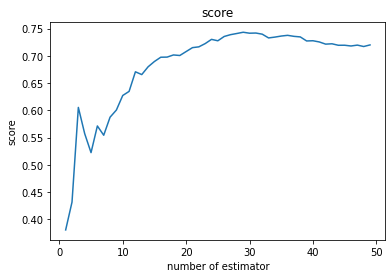

In [ ]:
#We plot the score graphe
plt.figure()
plt.title('score')
plt.plot(np.arange(1,50,1),score,label='validation set score')
plt.xlabel("number of estimator")
plt.ylabel("score")
plt.show()

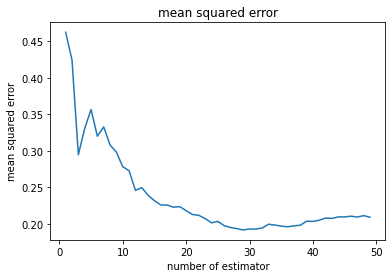

In [ ]:
#we plot the meanSquaredError graph
plt.figure()
plt.title('mean squared error')
plt.plot(np.arange(1,50,1),meanSquaredError,label='validation set mean squared error')
plt.xlabel("number of estimator")
plt.ylabel("mean squared error")
plt.show()

On remarque que l'on obtient un premier maximum pour n_estimator=7. C'est donc la valeur que l'on va retenir pour les tests.

In [ ]:
rg= RandomForestRegressor(n_estimators=7, random_state=0)
rg.fit(X_train, Y_train)
Y_pred = rg.predict(X_test)
print("score :" ,rg.score(X_test,Y_test))
print("mean squared error :", metrics.mean_squared_error(Y_test, Y_pred))

score : 0.7420305712350668
mean squared error : 0.28410535774612694


Le score du dataset d'entraînement est de 0.75 et son erreur quadratique de 0.11. On remarque donc qu'il y a un overfitting important et que l'erreur est quadruplet.
De plus les valeurs de score sont plus faible que pour les méthodes précédentes. Cette méthode est donc moins intéressant pour cette étude.




##6. Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

In [ ]:
train=X.sample(frac=0.6)
test_validation=X.drop(train.index)
test = test_validation.sample(frac=0.5)
validation = test_validation.drop(test.index)

#variable d'entrainement
X_train=train.drop('Y',axis=1)
Y_train=train['Y']

#variable de test
X_test=test.drop('Y',axis=1)
Y_test=test['Y']

#variable de validation
X_validation=validation.drop('Y',axis=1)
Y_validation = validation['Y']


In [ ]:
#We look for the number of estimator the most appropriate to decrease the error and increase the score
#do not revive

score=[]
meanSquaredError=[]
for i in range(1,50):  
  rg= RandomForestRegressor(n_estimators=i, random_state=0)
  rg.fit(X_train, Y_train)
  Y_pred = rg.predict(X_validation)
  score.append(rg.score(X_validation,Y_validation))
  meanSquaredError.append(metrics.mean_squared_error(Y_validation, Y_pred))
  

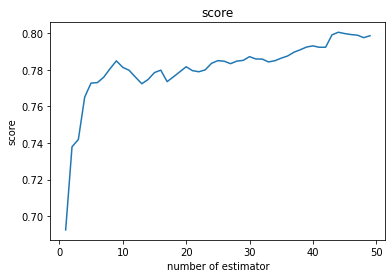

In [ ]:
#We plot the score graphe
plt.figure()
plt.title('score')
plt.plot(np.arange(1,50,1),score,label='validation set score')
plt.xlabel("number of estimator")
plt.ylabel("score")
plt.show()

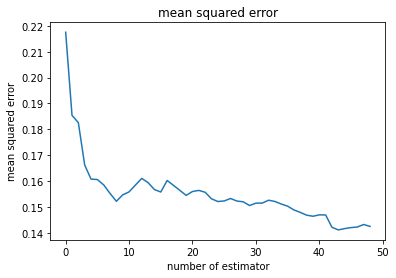

In [ ]:
#we plot the meanSquaredError graph
plt.figure()
plt.title('mean squared error')
plt.plot(np.arange(0,49,1),meanSquaredError,label='validation set mean squared error')
plt.xlabel("number of estimator")
plt.ylabel("mean squared error")
plt.show()


On remarque que l'on obtient un premier maximum pour n_estimator=8. C'est donc la valeur que l'on va retenir pour les tests.

In [ ]:
rg=GradientBoostingRegressor(n_estimators=8,learning_rate=0.1,max_depth=10)
rg.fit(X_train,Y_train)
Y_pred = rg.predict(X_test)
print("score :", rg.score(X_test,Y_test))
print("mean squared error :", metrics.mean_squared_error(Y_test, Y_pred))

score : 0.5698252842704123
mean squared error : 0.3708613917844071


Le score du dataset d'entraînement est de 0.78 et son erreur quadratique de 0.34. On a donc avec cette méthode beaucoup moins d'overfitting que pour les autres. De plus l'erreur quadratique est plus faible que pour la méthode précédente.
Cette méthode semble donc prometteuse pour notre cas.

# 7.Deep learning

In [ ]:
import numpy as np
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler
import tensorflow as tf

In [ ]:
train=X.sample(frac=0.6)
test_validation=X.drop(train.index)
test = test_validation.sample(frac=0.5)
validation = test_validation.drop(test.index)

#variable d'entrainement
X_train=train.drop('Y',axis=1)
Y_train=train['Y']

#variable de test
X_test=test.drop('Y',axis=1)
Y_test=test['Y']

#variable de validation
X_validation=validation.drop('Y',axis=1)
Y_validation = validation['Y']

In [ ]:
#convert the dataframe in torch.tensor
x_train=torch.tensor(X_train.values)
x_validation=torch.tensor(X_validation.values)
x_test=torch.tensor(X_test.values)
y_train=torch.tensor(Y_train.values)
y_validation=torch.tensor(Y_validation.values)
y_test=torch.tensor(Y_test.values)

In [ ]:
#create torch dataset
train_data = torch.utils.data.TensorDataset(x_train,y_train)
val_data = torch.utils.data.TensorDataset(x_validation,y_validation)
test_data = torch.utils.data.TensorDataset(x_test,y_test)

#create loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10)

In [ ]:
#Define the architecture and parameters used

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.input = nn.Linear(9,10)
        self.hidden = nn.Linear(10,10)
        self.output = nn.Linear(10,10)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

In [ ]:
model = NN()
print(model)

n_epochs = 40
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_losses=[]
validation_losses=[]


def train_model(model,train_dataloaders, val_dataloaders, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_train_loss = 0.0
        epoch_train_corrects = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Iterate over data.
        train_loss = 0.0
        train_corrects = 0
        for inputs, labels in train_dataloaders:

            
           
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            #forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            # statistics
            train_loss += loss.item() * inputs.size(0)
           
        scheduler.step()

        # Set model to evaluate mode
        model.eval()   
        
        validation_loss = 0.0
        # Iterate over data.
        for inputs, labels in val_dataloaders:
            if inputs.size()==torch.Size([10,9]):
              
              inputs = inputs.to(torch.float32)
              labels = labels.to(torch.float32)
  
              outputs = model(inputs)
              loss = criterion(outputs, labels)
    
              # zero the parameter gradients
              optimizer.zero_grad()

              # statistics
              validation_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = train_loss / len(train_loader.sampler) 
        epoch_validation_loss = validation_loss / len(train_loader.sampler) 
        train_losses.append(epoch_train_loss)
        validation_losses.append(epoch_validation_loss)

        print('{} Loss: {:.4f}   '.format(
                'train ', epoch_train_loss))
        print('{} Loss: {:.4f} '.format(
                'validation', epoch_validation_loss))
    return train_losses, validation_losses

NN(
  (input): Linear(in_features=9, out_features=10, bias=True)
  (hidden): Linear(in_features=10, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=10, bias=True)
  (activation): ReLU()
)


In [ ]:
train_losses,validation_losses= train_model(model,train_loader,val_loader,criterion,optimizer,scheduler,n_epochs)


Epoch 0/39
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



train  Loss: 1.1226   
validation Loss: 0.2829 
Epoch 1/39
----------
train  Loss: 1.1160   
validation Loss: 0.2827 
Epoch 2/39
----------
train  Loss: 1.1150   
validation Loss: 0.2827 
Epoch 3/39
----------
train  Loss: 1.1146   
validation Loss: 0.2825 
Epoch 4/39
----------
train  Loss: 1.1144   
validation Loss: 0.2825 
Epoch 5/39
----------
train  Loss: 1.1143   
validation Loss: 0.2825 
Epoch 6/39
----------
train  Loss: 1.1141   
validation Loss: 0.2825 
Epoch 7/39
----------
train  Loss: 1.1113   
validation Loss: 0.2825 
Epoch 8/39
----------
train  Loss: 1.1109   
validation Loss: 0.2825 
Epoch 9/39
----------
train  Loss: 1.1108   
validation Loss: 0.2824 
Epoch 10/39
----------
train  Loss: 1.1107   
validation Loss: 0.2824 
Epoch 11/39
----------
train  Loss: 1.1106   
validation Loss: 0.2824 
Epoch 12/39
----------
train  Loss: 1.1106   
validation Loss: 0.2824 
Epoch 13/39
----------
train  Loss: 1.1105   
validation Loss: 0.2824 
Epoch 14/39
----------
train  Loss: 1.

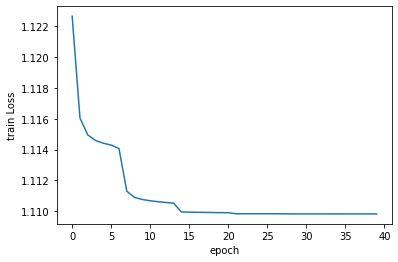

In [ ]:
plt.figure()
plt.plot(np.arange(40),train_losses, label='train set')
plt.xlabel('epoch')
plt.ylabel('train Loss')
plt.show()

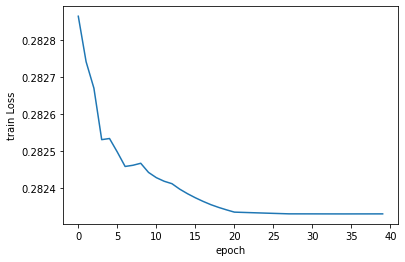

In [ ]:
plt.figure()
plt.plot(np.arange(40),validation_losses, label='train set')
plt.xlabel('epoch')
plt.ylabel('train Loss')
plt.show()

On remarque que la difference de valeur entre le set d'entraînement et le set de validation est très importante (0.6). Il y a donc beaucoup d'overfitting.

Enfin on remarque que la courbe est décroissante et converge vers  asymptote horizontale qui semble refleter la précision réelle de ce réseau de neurone. 
Sinon, cette méthode semble être la moins performante de toutes.

#III. Indice de Toxicité

## III.1 Clustering methode 

Création d'un dataframe prenant an compte les variables toxiques :


In [ ]:
dfTox=df[['nbrMotInsulte','nbrMotAllong','nbrMotMAJ','nbrExclMark']].copy()
for k in range(2,5):
  clu=KMeans(n_clusters=k,random_state=0).fit(dfTox)
  cluster_labels = clu.labels_ # Extract the labels
  dfTox['Cluster'+str(k)]=clu.labels_
  silhouette_avg = silhouette_score(dfTox, cluster_labels) # Corresponding silhouette score
  print(k,silhouette_avg)

2 0.9612169688053692
3 0.9372914638062938
4 0.917316189473797


In [ ]:
dfTox['Cluster2']=dfTox['Cluster2'].replace(1,'Toxique')
dfTox['Cluster2']=dfTox['Cluster2'].replace(0,'Non Toxique')
dfTox['Cluster3']=dfTox['Cluster3'].replace(2,'Toxique')
dfTox['Cluster3']=dfTox['Cluster3'].replace(1,'Peu Toxique')
dfTox['Cluster3']=dfTox['Cluster3'].replace(0,'Non Toxique')
dfTox['Cluster4']=dfTox['Cluster4'].replace(3,'TrèsToxique')
dfTox['Cluster4']=dfTox['Cluster4'].replace(2,'Toxique')
dfTox['Cluster4']=dfTox['Cluster4'].replace(1,'Peu Toxique')
dfTox['Cluster4']=dfTox['Cluster4'].replace(0,'Non Toxique')

In [ ]:
fig = px.scatter_matrix(dfTox, dimensions=["nbrMotInsulte", 'nbrMotAllong', "nbrMotMAJ","nbrExclMark"],color='Cluster2', height = 760)
fig

In [ ]:
fig = px.scatter_matrix(dfTox, dimensions=["nbrMotInsulte", 'nbrMotAllong', "nbrMotMAJ","nbrExclMark"],color='Cluster3', height = 760)
fig

In [ ]:
fig = px.scatter_matrix(dfTox, dimensions=["nbrMotInsulte", 'nbrMotAllong', "nbrMotMAJ","nbrExclMark"],color='Cluster4', height = 760)
fig

In [ ]:
#On peut essayer de voir si ces résultats peuvent être obtenu par regression logistique sur un nouvel échantillon.

In [ ]:
dfToX=df.drop(["video_id_court","video_id","channel_id","channel_name","categorie_new","categ_inst","nbrMotInsulte", 'nbrMotAllong', "nbrMotMAJ","nbrExclMark","nbrMotInsulteMoyenne", 'nbrMotAllongMoyenne', "nbrMotMAJMoyenne","nbrExclMarkMoyenne"],axis=1)
dfToX['Cluster2']=dfTox['Cluster2'].replace('Non Toxique',0).replace('Toxique',1)
train=dfToX.sample(frac=0.6)
test_validation=dfToX.drop(train.index)
test = test_validation.sample(frac=0.5)
validation = test_validation.drop(test.index)

In [ ]:
dfToX

nbrMot  nbrQuestMark  ...  viewCount  Cluster2
0        3813            60  ...  225393312         0
1          28             0  ...  132125693         0
2        3804            54  ...  225393312         0
3           4             0  ...    2481100         0
4         737             6  ...    6710737         0
...       ...           ...  ...        ...       ...
46097      16             0  ...   85536183         0
46098     228             1  ...  134570352         0
46099     287             0  ...  132125693         0
46100     176             3  ...  140135417         0
46101   16608           179  ...  225393312         0

[46083 rows x 14 columns]

In [ ]:
#variable d'entrainement
X_train=train.drop('Cluster2',axis=1)
Y_train=train['Cluster2']

#variable de test
X_test=test.drop('Cluster2',axis=1)
Y_test=test['Cluster2']

#variable de validation
X_validation=validation.drop('Cluster2',axis=1)
Y_validation = validation['Cluster2']

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1).fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.9839409722222222

On trouve une valeur proche de 1 c'est très satisfaisant.



## III.2 Methode de repartition entre 0 et 1 en se basant sur commentaire injurieux classique 

On decide d'introduire un indice de toxicité entre 0 et 1 mais egalement un pourcentage de fiabilité associé a cet indice.

cet indice sera basé sur :

* le nombre moyen d'insultes
* le nombre moyen de points d'exclamations
* le nombre moyen de points d'interoogations
* le nombre moyen de majuscules
* la taille moyenne d'un commentaire

Pour savoir quel est l'importance de tous ces facteurs les uns par rapport aux autres, on va comparer le rapport entre la moyenne (de chacun des facteurs) pour un message injurieux moyen et pour un message moyen.
Pour avoir les données d'un message moyen on prendra les données du dataframe principal df, et pour celles des commentaires injureiux on prendra le dataframe df_1insul qui a été crée lors de l'analyse des données et qui contient des videos a 1 commentaire tous injurieux.

In [ ]:
facteur_insultes = df_1insult.nbrMotInsulteMoyenne.mean(axis = 0)/df.nbrMotInsulteMoyenne.mean(axis = 0)
facteur_maj = df_1insult.nbrMotMAJMoyenne.mean(axis = 0)/df.nbrMotMAJMoyenne.mean(axis = 0)
facteur_excl = df_1insult.nbrExclMarkMoyenne.mean(axis = 0)/df.nbrExclMarkMoyenne.mean(axis = 0)
facteur_int = df_1insult.nbrQuestMarkMoyenne.mean(axis = 0)/df.nbrQuestMarkMoyenne.mean(axis = 0) 
facteur_taille_moyenne = df_1insult.nbrMotMoyenne.mean(axis = 0)/df.nbrMotMoyenne.mean(axis = 0) 

total = facteur_insultes + facteur_maj +facteur_excl + facteur_int + facteur_taille_moyenne

pctage_insultes = (facteur_insultes/total) *100
pctage_maj = 100*facteur_maj/total
pctage_excl = 100*facteur_excl/total
pctage_int = 100*facteur_int/total
pctage_taille_moyenne = 100*facteur_taille_moyenne/total
print ('part du nombre moyen insultes :' , end=" ") ; print(pctage_insultes,end=" ") ; print('%')
print ('part de la proportion de majuscules :' , end=" ") ; print(pctage_maj,end=" ") ; print('%')
print ('part de la proportion de points d exclamation :' , end=" ") ; print(pctage_excl,end=" ") ; print('%')
print ('part de la proportion de points d interrogations :' , end=" ") ; print(pctage_int,end=" ") ; print('%')
print ('part de la taille moyenne d un commentaire:' , end=" ") ; print(pctage_taille_moyenne,end=" ") ; print('%')

part du nombre moyen insultes : 50.93246768362234 %
part de la proportion de majuscules : 16.80110342288211 %
part de la proportion de points d exclamation : 12.118572767598877 %
part de la proportion de points d interrogations : 8.735688262204059 %
part de la taille moyenne d un commentaire: 11.412167863692616 %


* On retiendra donc 51% pour la part du nombre moyen insultes, 17% pour la part de la proportion de majuscules, 12% pour la part de la proportion de point d'exclamations, 9% pour la part de la proportion de point d'interrogations et 11% pour la part de la taille moyenne d'un commentaire.
d'ou le code suivant pour l'indice de toxicité :

In [ ]:
def tox_score(row):
  if (row.nbrExclMark<row.nbrMot and row.nbrQuestMark<row.nbrMot ):
    return ((0.51*row.nbrMotInsulte/row.nbrMot) + (0.17*row.nbrMotMAJ/row.nbrMot) + (0.12*row.nbrExclMark/row.nbrMot) + (0.05*row.nbrQuestMark/row.nbrMot) + (0.11*row.nbrMotMoyenne/row.nbrMot))
  else:
    return 1 

df['toxicity_score'] = df.apply(tox_score, axis=1)

Ce qui donne en repartition :

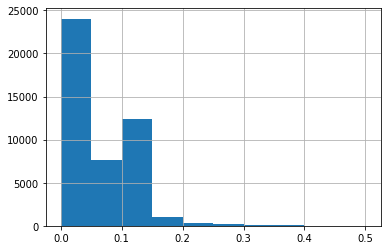

In [ ]:
df['toxicity_score'].hist(range=[0, 0.5],)

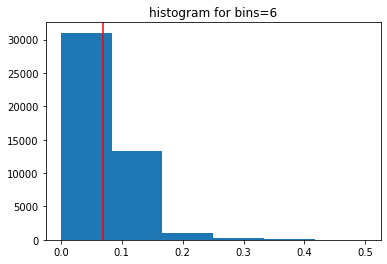

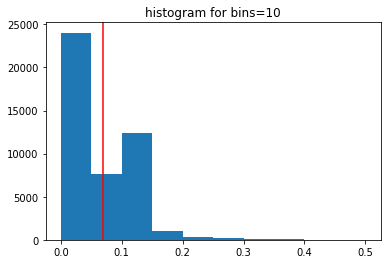

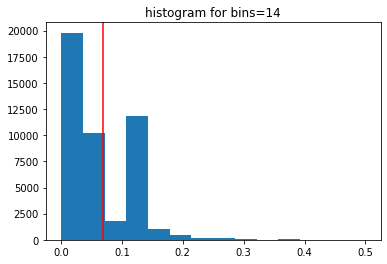

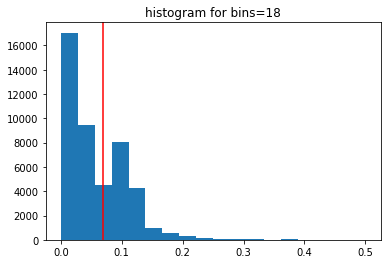

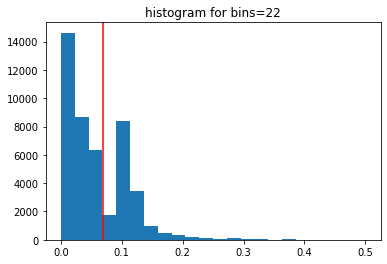

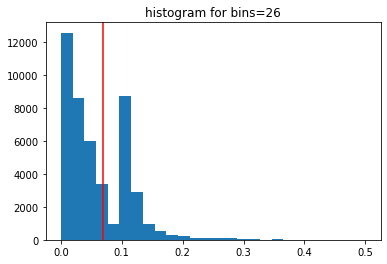

In [ ]:
for i in range(6,28,4):
        plt.figure()
        plt.hist(x='toxicity_score',data=df,bins=i,range=[0, 0.5])
        plt.axvline(df['toxicity_score'].mean(),color='red') # add the mean value of tip to our plots
        plt.title('histogram for bins='+str(i))

On va decider de l'etaler grace a une fformule logarithmique:

In [ ]:
from cmath import *
def etaler(row):
    return((log(1 +(9*row.toxicity_score))/log(10)).real)
df['toxicity_score_etalée'] = df.apply(etaler, axis=1)

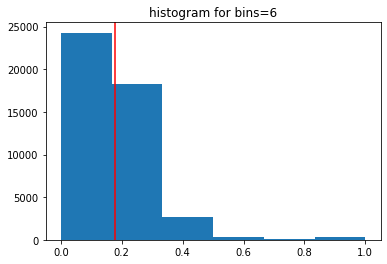

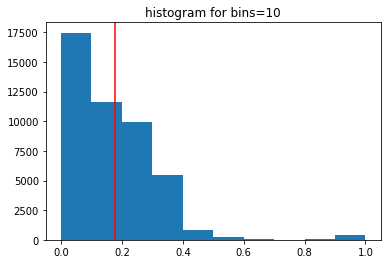

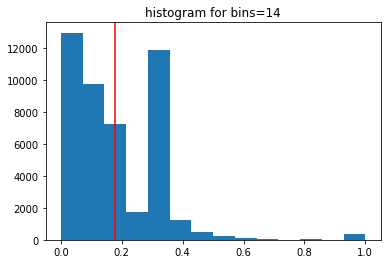

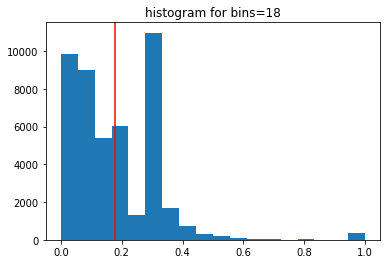

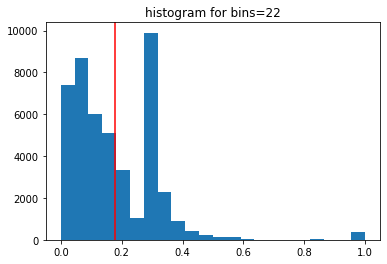

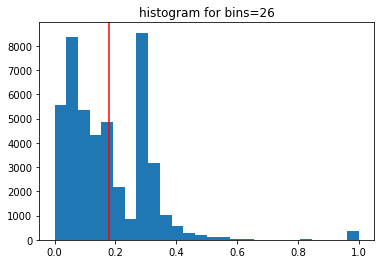

In [ ]:
for i in range(6,28,4):
        plt.figure()
        plt.hist(x='toxicity_score_etalée',data=df,bins=i,range=[0, 1])
        plt.axvline(df['toxicity_score_etalée'].mean(),color='red') # add the mean value of tip to our plots
        plt.title('histogram for bins='+str(i))

Notre repartition donne en effet un bien meilleur resultat que si on avait considéré juste la moyenne des insultes
En effet : 

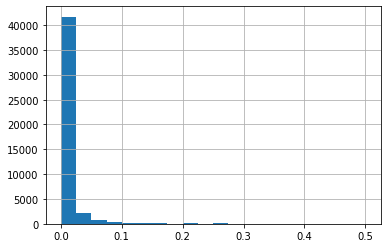

In [ ]:
def tox_score1(row):
  if (row.nbrExclMark<row.nbrMot and row.nbrQuestMark<row.nbrMot ):
    return(row.nbrMotInsulte/row.nbrMot )
  else: 
    return 1
df['toxicity_score1'] = df.apply(tox_score1, axis=1)
df['toxicity_score1'].hist(range=[0, 0.5],bins =20)

Ce qui donne une assez mauvaise repartition 

### Passons a la mise en place de l'indice de confiance 

Mettons maintenant un indice de confiance de cet indice de toxicité, en effet si il n'y a qu'un commentaire et qu'il est injrieux la video va etre qualifiée de toxique mais pourtant cela n'est pas très pertinent. Il convient de dire qu'au deesu de dis fois la moyenne (10x 48) du nombre de commentaire la confiance est exellente. Créons une échelle logaritmique afin de ne pas trop penaliser les petite vidéos.

In [ ]:
from cmath import *
def confiance(row):
  if (row.message_count > 9):
    return (1)
  else :
    return ((log(1+(9*row.message_count/480))/log(10)).real)
df['confiance'] = df.apply(confiance, axis=1)

On a ainsi un indice de confiance associé a chaque valeur de toxicité 

### Si l'on represente comme avec la technique précedente :

In [ ]:
fig = px.scatter_matrix(df, dimensions=["nbrMotInsulte","nbrMotMAJ","nbrExclMark","nbrMotAllong"],color='toxicity_score_etalée', height = 760, color_continuous_scale='rainbow',range_color= (0,0.5))
fig

In [ ]:
df['Toxique']=(df['toxicity_score_etalée']>0.1).replace(True,'Toxique').replace(False,'Non Toxique')

In [ ]:
fig = px.scatter_matrix(df, dimensions=["nbrMotInsulte","nbrMotMAJ","nbrExclMark","nbrMotAllong"],color='Toxique', height = 760,)
fig